In [1]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/')
%load_ext autoreload
%autoreload 2
from src.misc import load_processed_dataset, evaluate, load_csv_to_df
import torch
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

In [69]:
load_csv_to_df("data/raw/JPM.csv")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-17 05:00:00,0.000000,1.103640,1.079734,1.083718,62775,0.0,0.0
1980-03-18 05:00:00,0.000000,1.099656,1.083719,1.091687,64125,0.0,0.0
1980-03-19 05:00:00,0.000000,1.111609,1.099656,1.107624,40500,0.0,0.0
1980-03-20 05:00:00,0.000000,1.107624,1.095672,1.099656,18900,0.0,0.0
1980-03-21 05:00:00,0.000000,1.123561,1.099655,1.123561,97200,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-27 04:00:00,196.500000,199.600006,196.380005,199.520004,8725800,0.0,0.0
2024-03-28 04:00:00,199.490005,200.720001,198.539993,200.300003,8628300,0.0,0.0
2024-04-01 04:00:00,199.990005,200.940002,198.570007,198.940002,7309000,0.0,0.0


In [70]:
load_processed_dataset("jpm", "2019-01-1", "2024-01-1").columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'log_return',
       'log_return_open', 'log_return_high', 'log_return_low',
       'log_return_volume', 'log_return_forecast', 'sma', 'wma', 'ema', 'dema',
       'tema', 'aroon', 'rsi', 'willr', 'cci', 'ad', 'mom', 'slowk', 'slowd',
       'macd', 'fed_funds_rate', '^N225', '^IXIC', '^FTSE', '^SPX', '^DJI'],
      dtype='object')

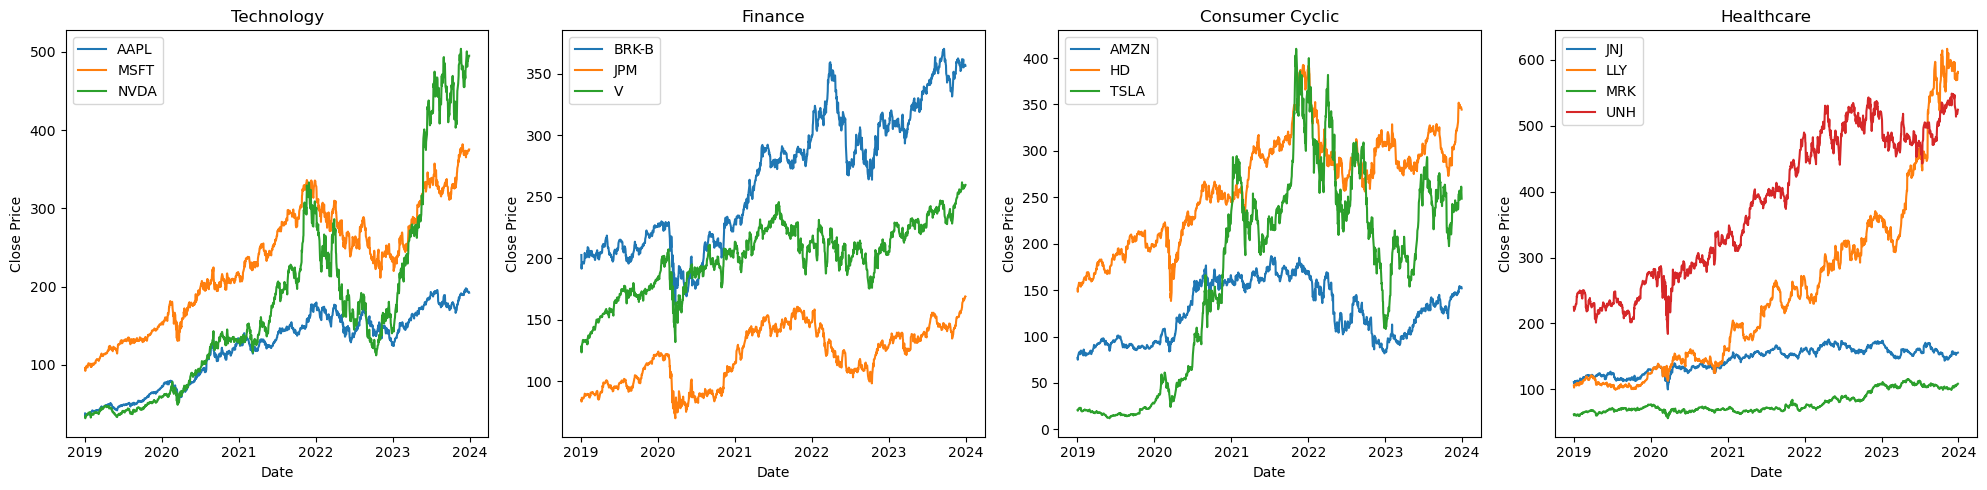

In [71]:
all_stocks = ["aapl", "amzn", "avgo", "brk-b", "cost", "hd", "jnj", "jpm", "lly", "ma", "meta", "mrk", "msft", "nvda", "pg", "tsla", "unh", "v", "xom"]
sectors = {
    "technology": ["aapl", "msft", "nvda"],
    "finance": ["brk-b", "jpm", "v"],
    "consumer cyclic": ["amzn", "hd", "tsla"],
    "healthcare": ["jnj", "lly", "mrk", "unh"]
}

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, (name, stocks) in enumerate(sectors.items()):
    for s in stocks:
        df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
        axs[i].plot(df.index, df['Close'], label=s.upper())
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Close Price')
    axs[i].legend()
    axs[i].set_title(name.title())
fig.tight_layout()
plt.show()


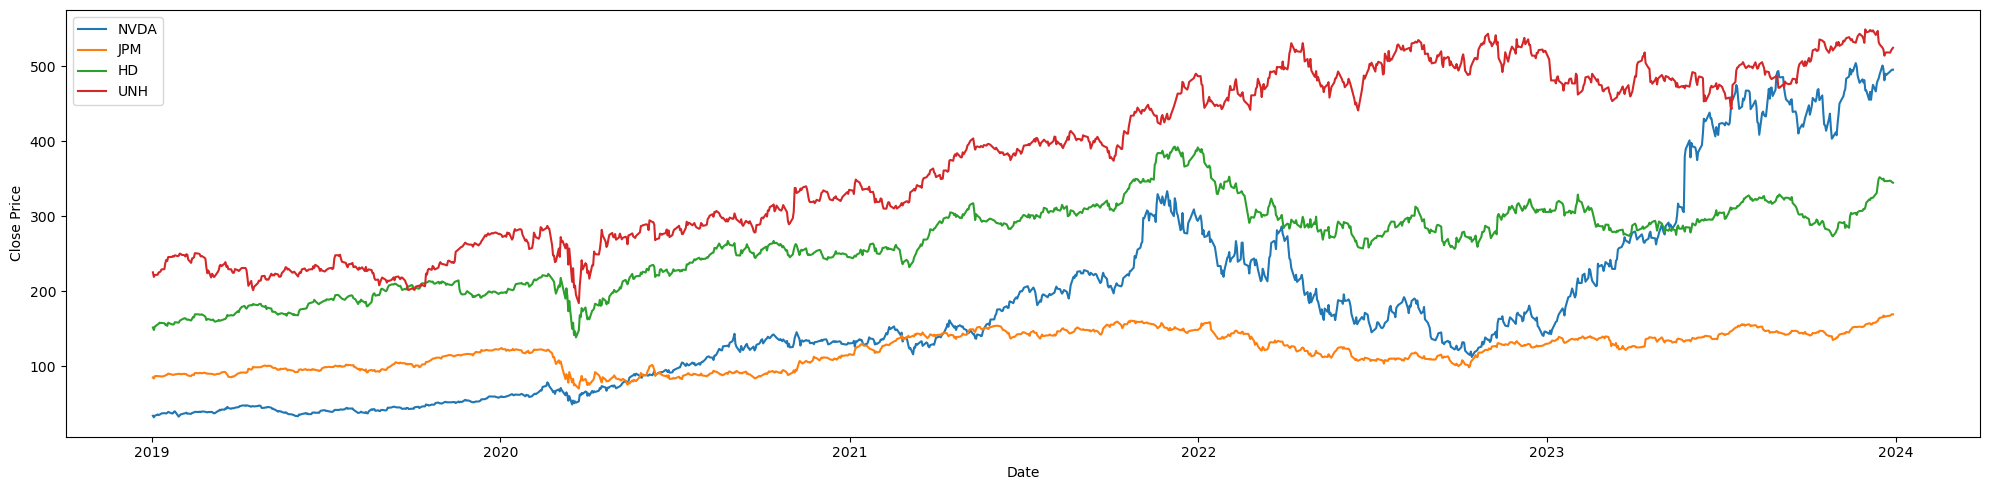

In [72]:
selected = ["nvda", "jpm", "hd", "unh"]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for s in selected:
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    ax.plot(df.index, df['Close'], label=s.upper())
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
fig.tight_layout()
plt.show()

We should not use price as our target variable. Firstly, it is non-stationary. We want our model to be time invariant. Secondly, can't extrapolate. 

We don't care about level information. If our goal is to profit, we only care about the direction of the stock. Hence, using percentage change or returns would be more suitable.

In fact, we use log returns, because ...

Still non-constant variance, we have volatilty clustering. Some models like GARCH aim to model this.

The same logic applies to using return instead of price as our inputs.

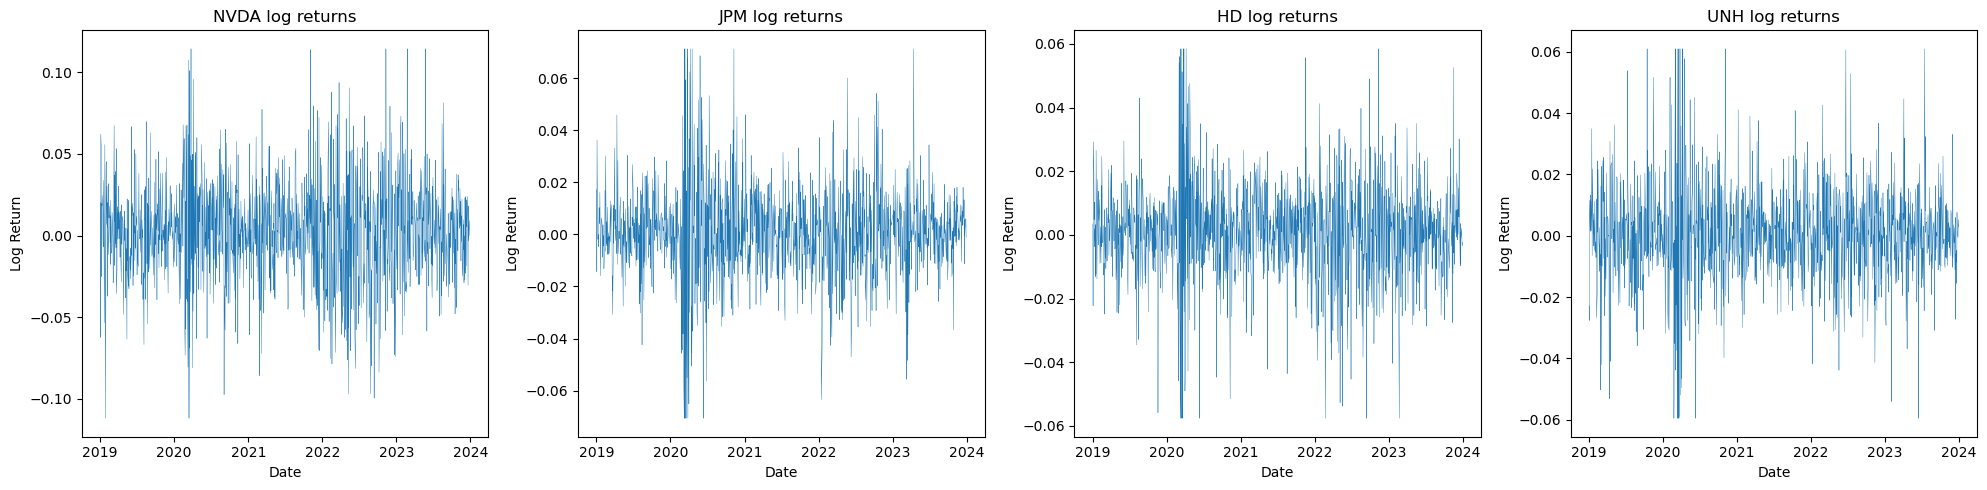

In [73]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    axs[i].plot(df.index, df['log_return'], linewidth=0.3)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Log Return')
    axs[i].set_title(f"{s.upper()} log returns")
fig.tight_layout()
plt.show()

For normalisation, we choose Z-score normalisation (standardisation) over Min-Max. Since normalisation only fitted to the training data to prevent data leakage, using min max constrains values to the range of the train set, even though our test data might very well have values above those in the train set.

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na op

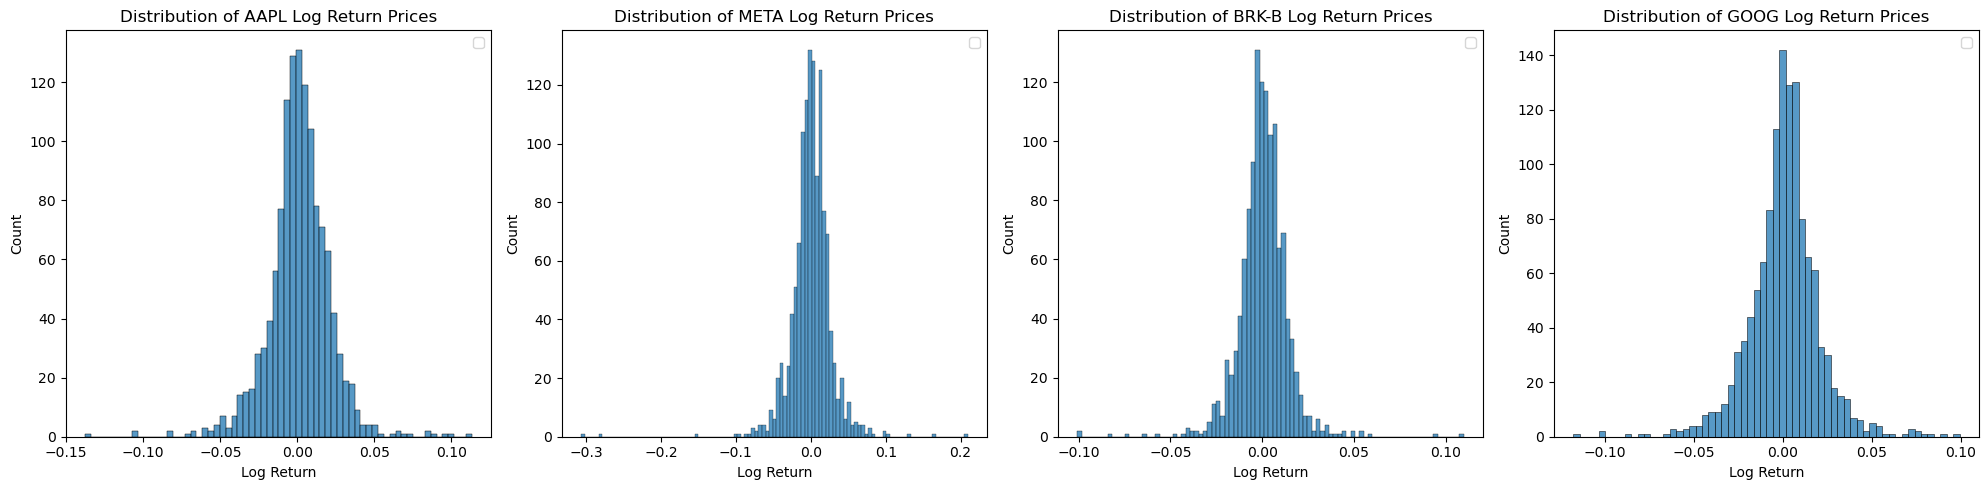

In [74]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
selected = ["aapl", "meta", "brk-b", "goog"]

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    sns.histplot(df['log_return_forecast'], kde=False, ax=axs[i], stat="count")
    axs[i].set_title(f'Distribution of {s.upper()} Log Return Prices')
    axs[i].set_xlabel('Log Return')
    axs[i].legend()
fig.tight_layout()
plt.show()

Original std: 0.019478350265748862
Original std: 0.023595610450688143
Original std: 0.012110960260730257
Original std: 0.018402071500550832


/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

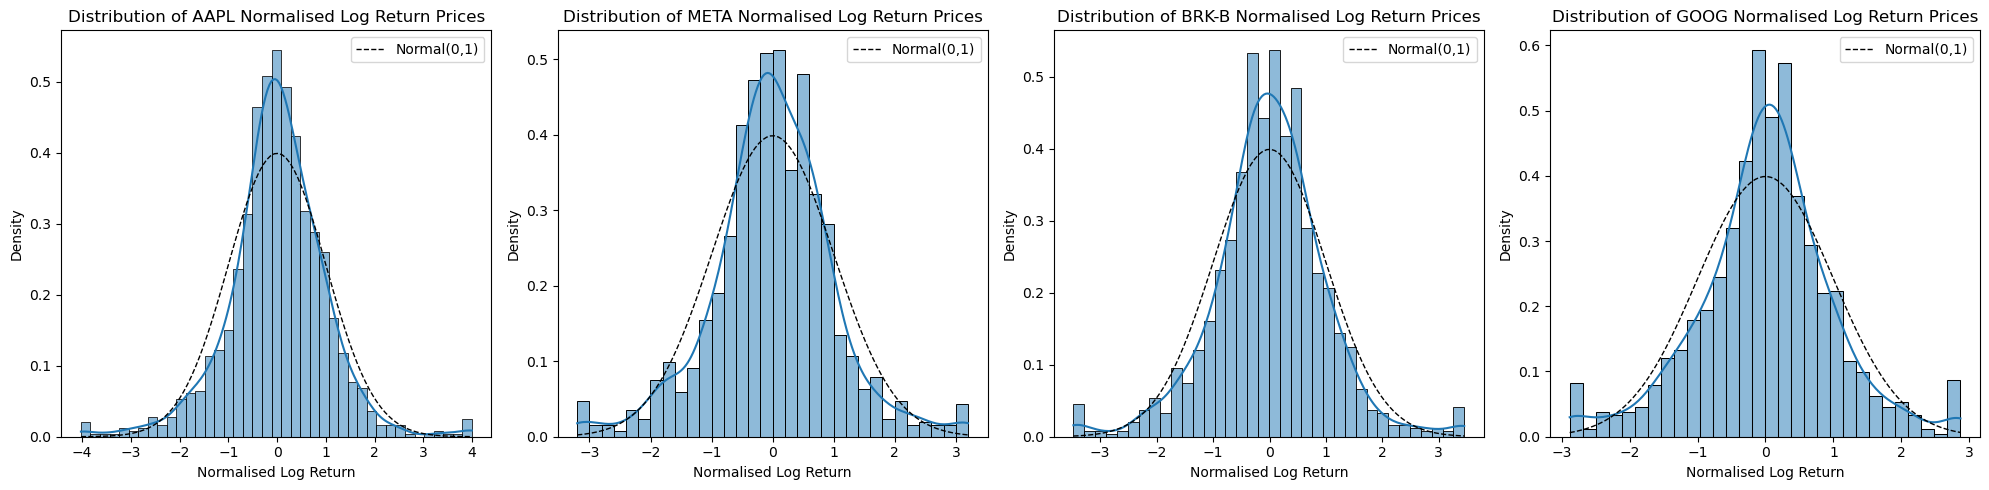

In [75]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")

    mean = df['log_return'].mean()
    std = df['log_return'].std()
    print(f"Original std: {std}")
    norm_log_return = (df['log_return'] - mean) / std
    # axs[i].hist(df['log_return'], bins=100, label=s)
    sns.histplot(norm_log_return, kde=True, ax=axs[i], stat="density")
    axs[i].set_title(f'Distribution of {s.upper()} Normalised Log Return Prices')
    axs[i].set_xlabel('Normalised Log Return')

    x = np.linspace(min(norm_log_return), max(norm_log_return), 100)
    p = stats.norm.pdf(x, 0, 1)
    axs[i].plot(x, p, 'k', linewidth=1, label=f'Normal(0,1)', linestyle="--")
    axs[i].legend()
fig.tight_layout()
plt.show()

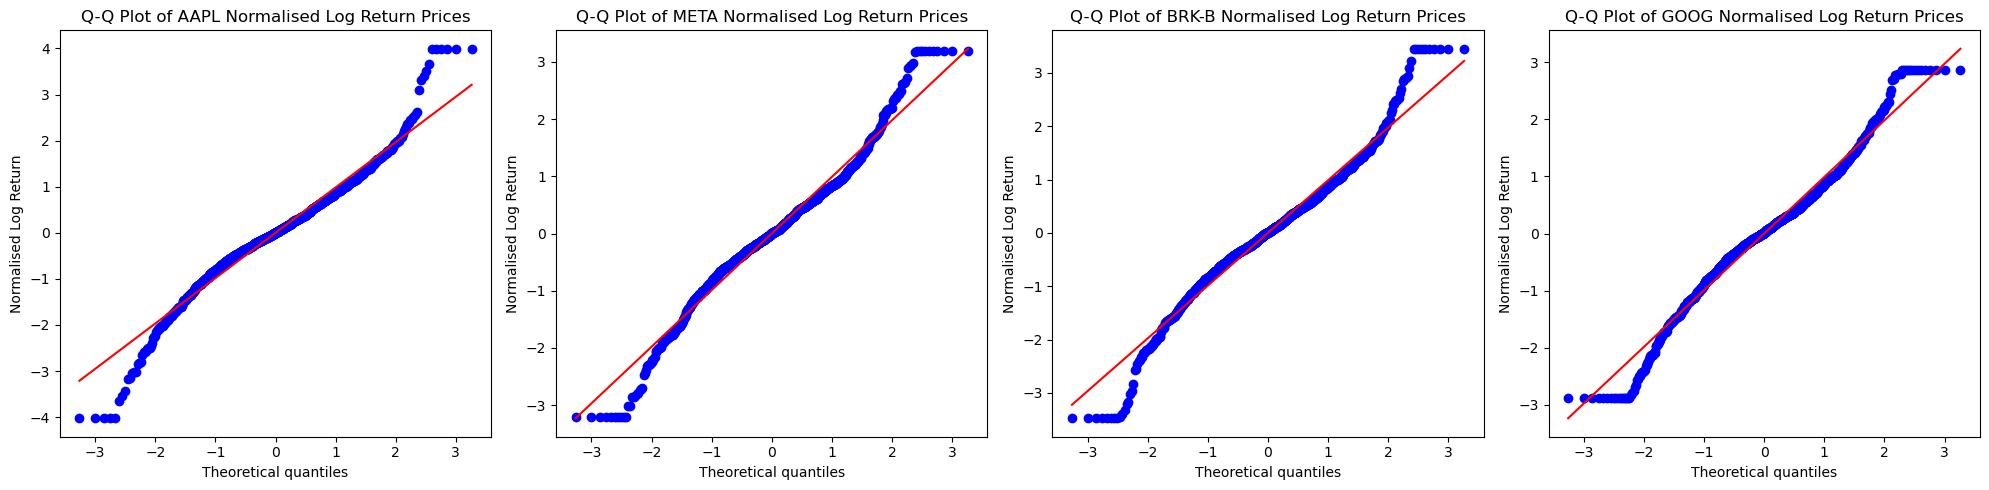

In [76]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    mean = df['log_return'].mean()
    std = df['log_return'].std()
    norm_log_return = (df['log_return'] - mean) / std
    # Q-Q plot
    stats.probplot(norm_log_return, dist="norm", plot=axs[i])
    axs[i].set_title(f'Q-Q Plot of {s.upper()} Normalised Log Return Prices')
    axs[i].set_ylabel('Normalised Log Return')
fig.tight_layout()
plt.show()

Although log return has many characterstics, being ...

It is not normally distributed. It has long tails. Using MSE loss means long tails will be penalised heavily much more than getting the middle of the distribution wrong. So our model will care about getting tail values rather than middle values. Therefore we use Huber loss because it is more lax on errors above a threshold. So we will set the threshold to 1, one standard deviation.

Carefully tuned SGD is better than Adam, so we use SGD. Also we use eight decay 1e-06.

Now we can look at R^2 metric to see if predictions are correlated.

Potential reasons for poor performance:
- Overfitting noisy data. Model finds mirage patterns.
- Not enough data. Trading minutes instead of days?
- Model does not have the right structure to extract insights.

Now it is important to diagnose residuals. We would like to residuals to be uncorerelated and zero mean. If there is correlation between residuals, then there is information left in the residuals which can be used in computing the forecast. If the residuals have non-zero mean, then our forecasts are biased. Ideally, it woudld also be nice, but not necessary, to have constant variance and a normal distribution which make calculation of prediction intervals easier.

So residuals plot show whether our forecasts appear to account for all information. Talk about the
- Mean of residuals close to zero? (Histogram)
- Correlation in residuals series? (ACF)
- Variation of residuals constant? (Time series, histogram)
- Normal distribution (histogram) or tails too long? Even when ignoring outlioers? If not normal, confidence intervals computed assuming a normal distribution will be inaccurate.

A prediction interval gives an interval in which we expect $y_t$ to lie with a specified probability. A prediction interval for a $h$-step forecast is
$$
\hat{y}_{T+h}\pm c\hat\sigma_h
$$
where $c$ depends on the coverage probability, $\hat\sigma_h$ is the estimated standard deviation of the $h$-step forecast distribution.

For one-step ahead forecasts, the standard deviation of the forecast is almost the same as the standard deviation of the residuals. So if we have a prediction of 531.48, and the standard deviation of our residuals is 6.21, our 95% interval is 531.48$\pm$ 1.96(6.21), since we are assuming a normal distirbution, and 95% of the probability mass in a normal distribution falls within 1.96 standard deviations on either side of it.

However, if a normal distribution for forecast errors is an unreasonable assumption, we can use bootstrapping. We sample from the residuals and repeatedly simulate a set of future values. Then we calculate percentiles for each forecast horizon.

NB. if transformations has been used, the prediction interval should be computed on the transformed scale, and the end points inverse-transformed to give a prediction interval on the original scale. May not be symmetric around point forecast.

Linear regression assumptions:
- Relationship between target variable and predictor variable is a reasonable approximation to reality
- The errors:
    - have zero mean, otherwise forecasts will be systematically biased
    - not autocorrelated, otherwise inefficient forecasts as more information able ot be exlpoited
    - unrelated to the predictor variable, otherwise there is more information that could be included
Also useful to have nromally distributed, constant variance errors to easily produce prediction intervals.

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    axs[i].plot(df.index, df['log_return'], linewidth=0.3)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Log Return')
    axs[i].set_title(f"{s.upper()} log returns")
fig.tight_layout()
plt.show()

Let' plot return against its forecast

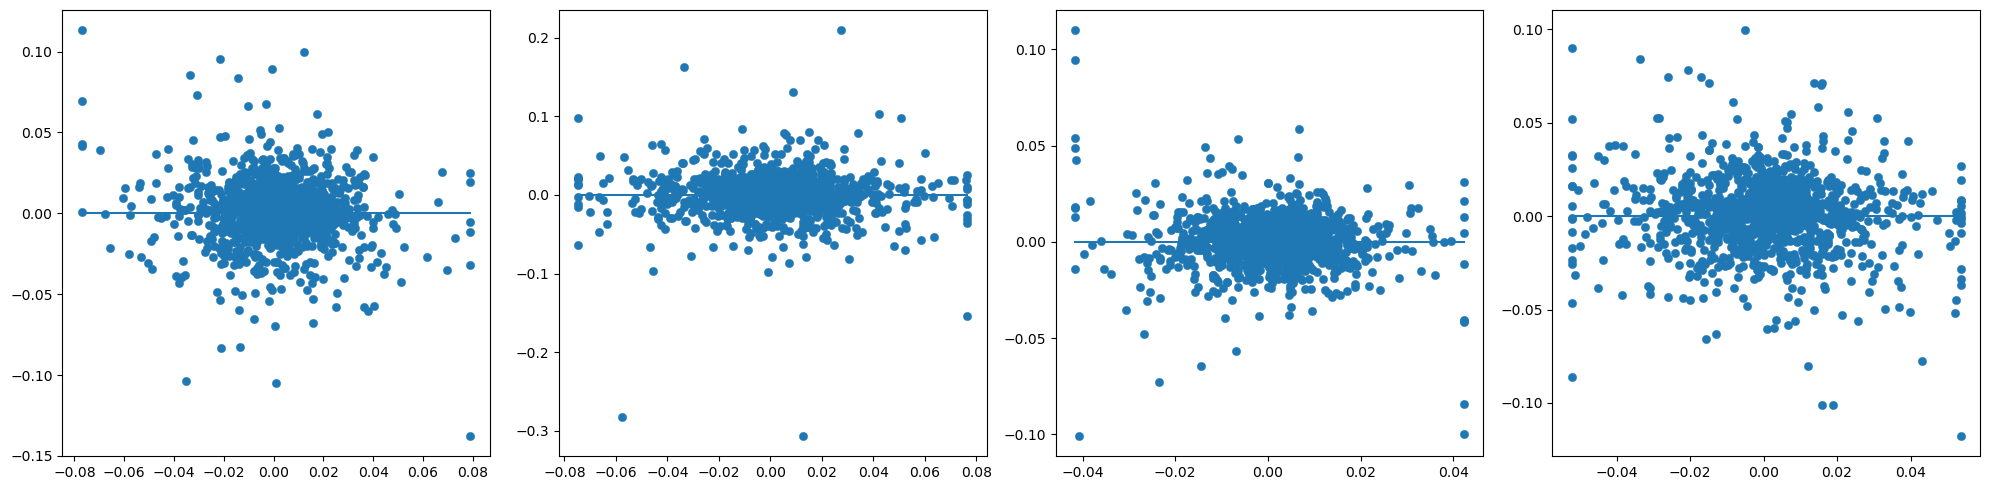

In [77]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    feature = "Dividends"
    axs[i].scatter(df["log_return"], df["log_return_forecast"], label=s, linewidth=0.3)
    # axs[i].set_xlabel('Date')
    # axs[i].set_ylabel(feature)
    # axs[i].set_title(f"{s} log returns")
    x = np.linspace(start=df["log_return"].min(), stop=df["log_return"].max(), num=100)
    y = np.zeros(len(x))
    axs[i].plot(x, y)
fig.tight_layout()
plt.show()

In [78]:
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(42)

df = load_processed_dataset("nvda", "2004-01-1", "2024-01-1").sample(1000)
features = [ 'log_return',
       'log_return_open', 'log_return_high', 'log_return_low',
       'log_return_volume', 'log_return_forecast', 'sma', 'wma', 'ema', 'dema',
       'tema', 'aroon', 'rsi', 'willr', 'cci', 'ad', 'mom', 'slowk', 'slowd',
       'macd', 'fed_funds_rate', '^N225', '^IXIC', '^FTSE', '^SPX', '^DJI']

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

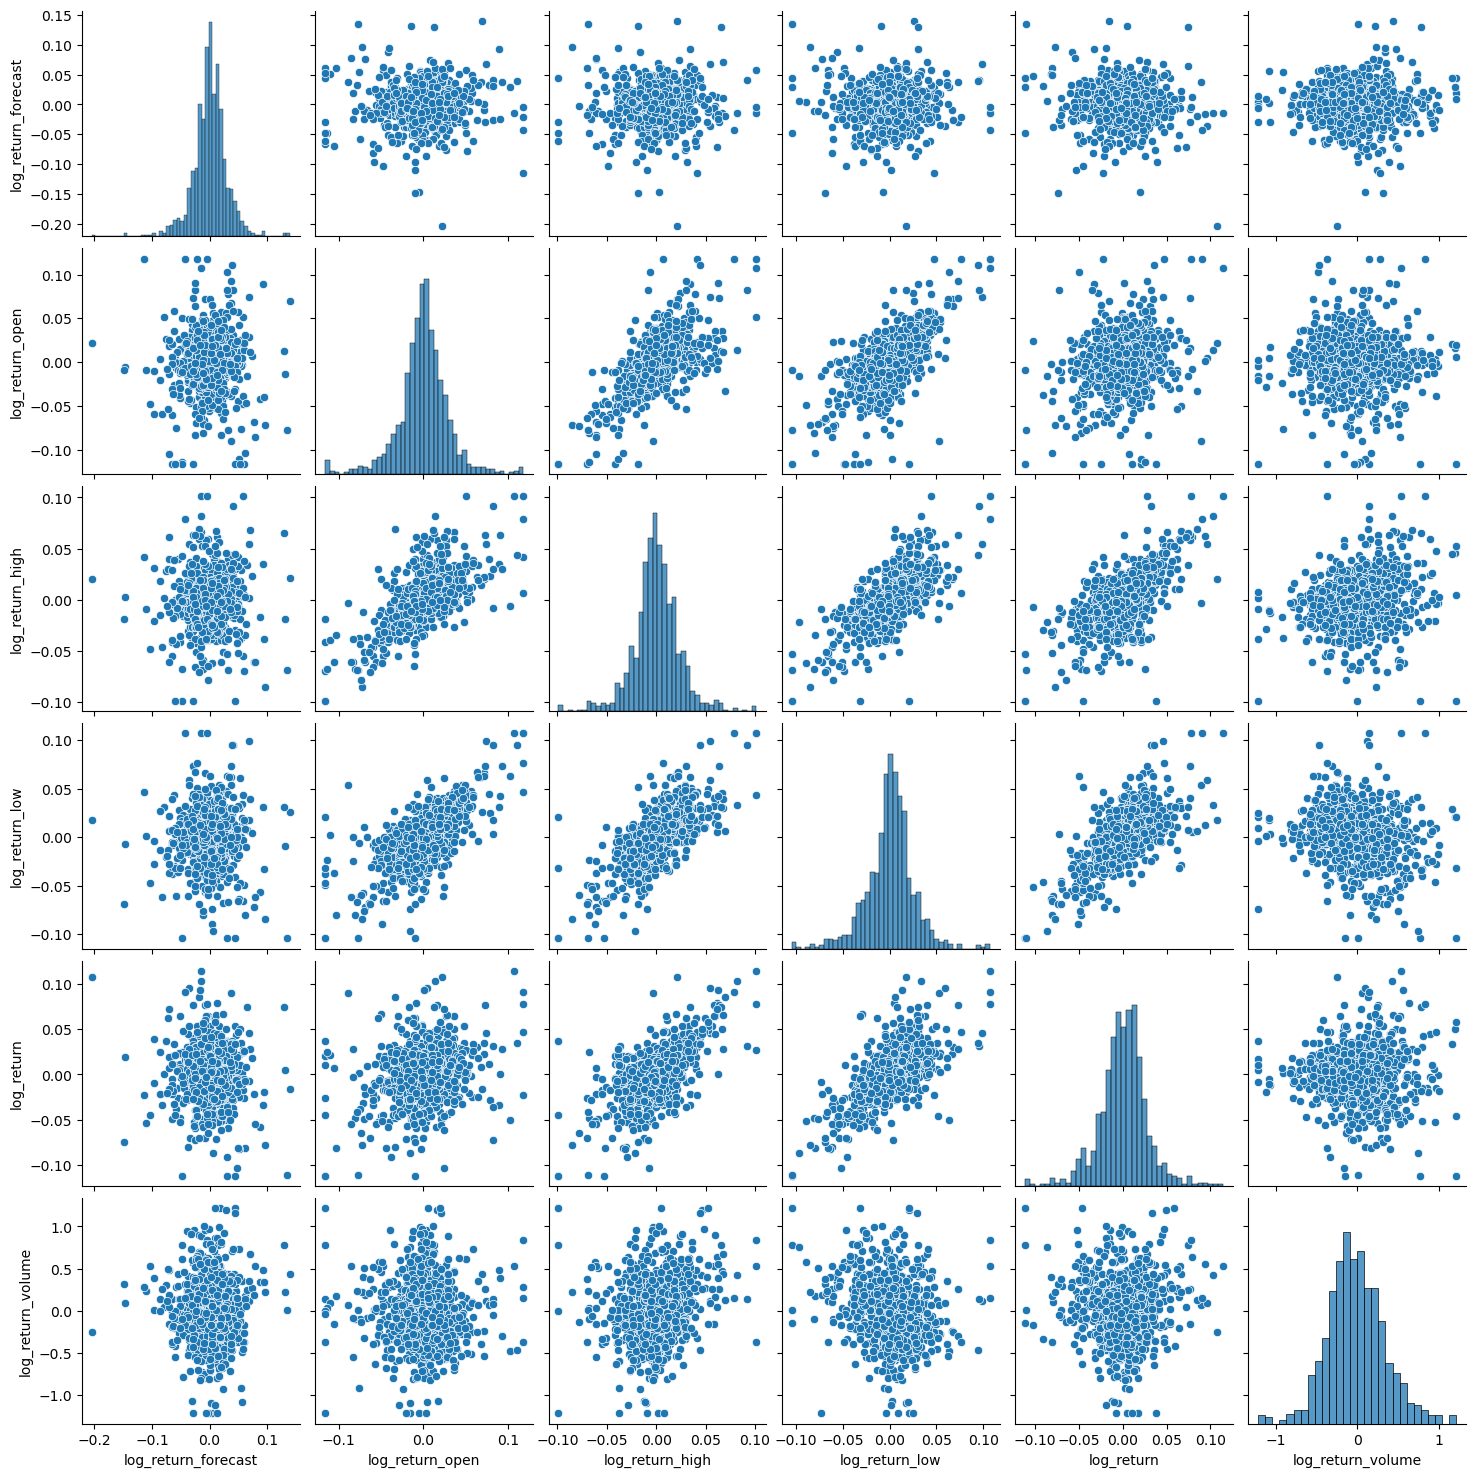

In [79]:
features = ['log_return_forecast',
       'log_return_open', 'log_return_high', 'log_return_low',
       'log_return', 'log_return_volume']
_ = sns.pairplot(df[features], kind="scatter", diag_kind="hist")

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

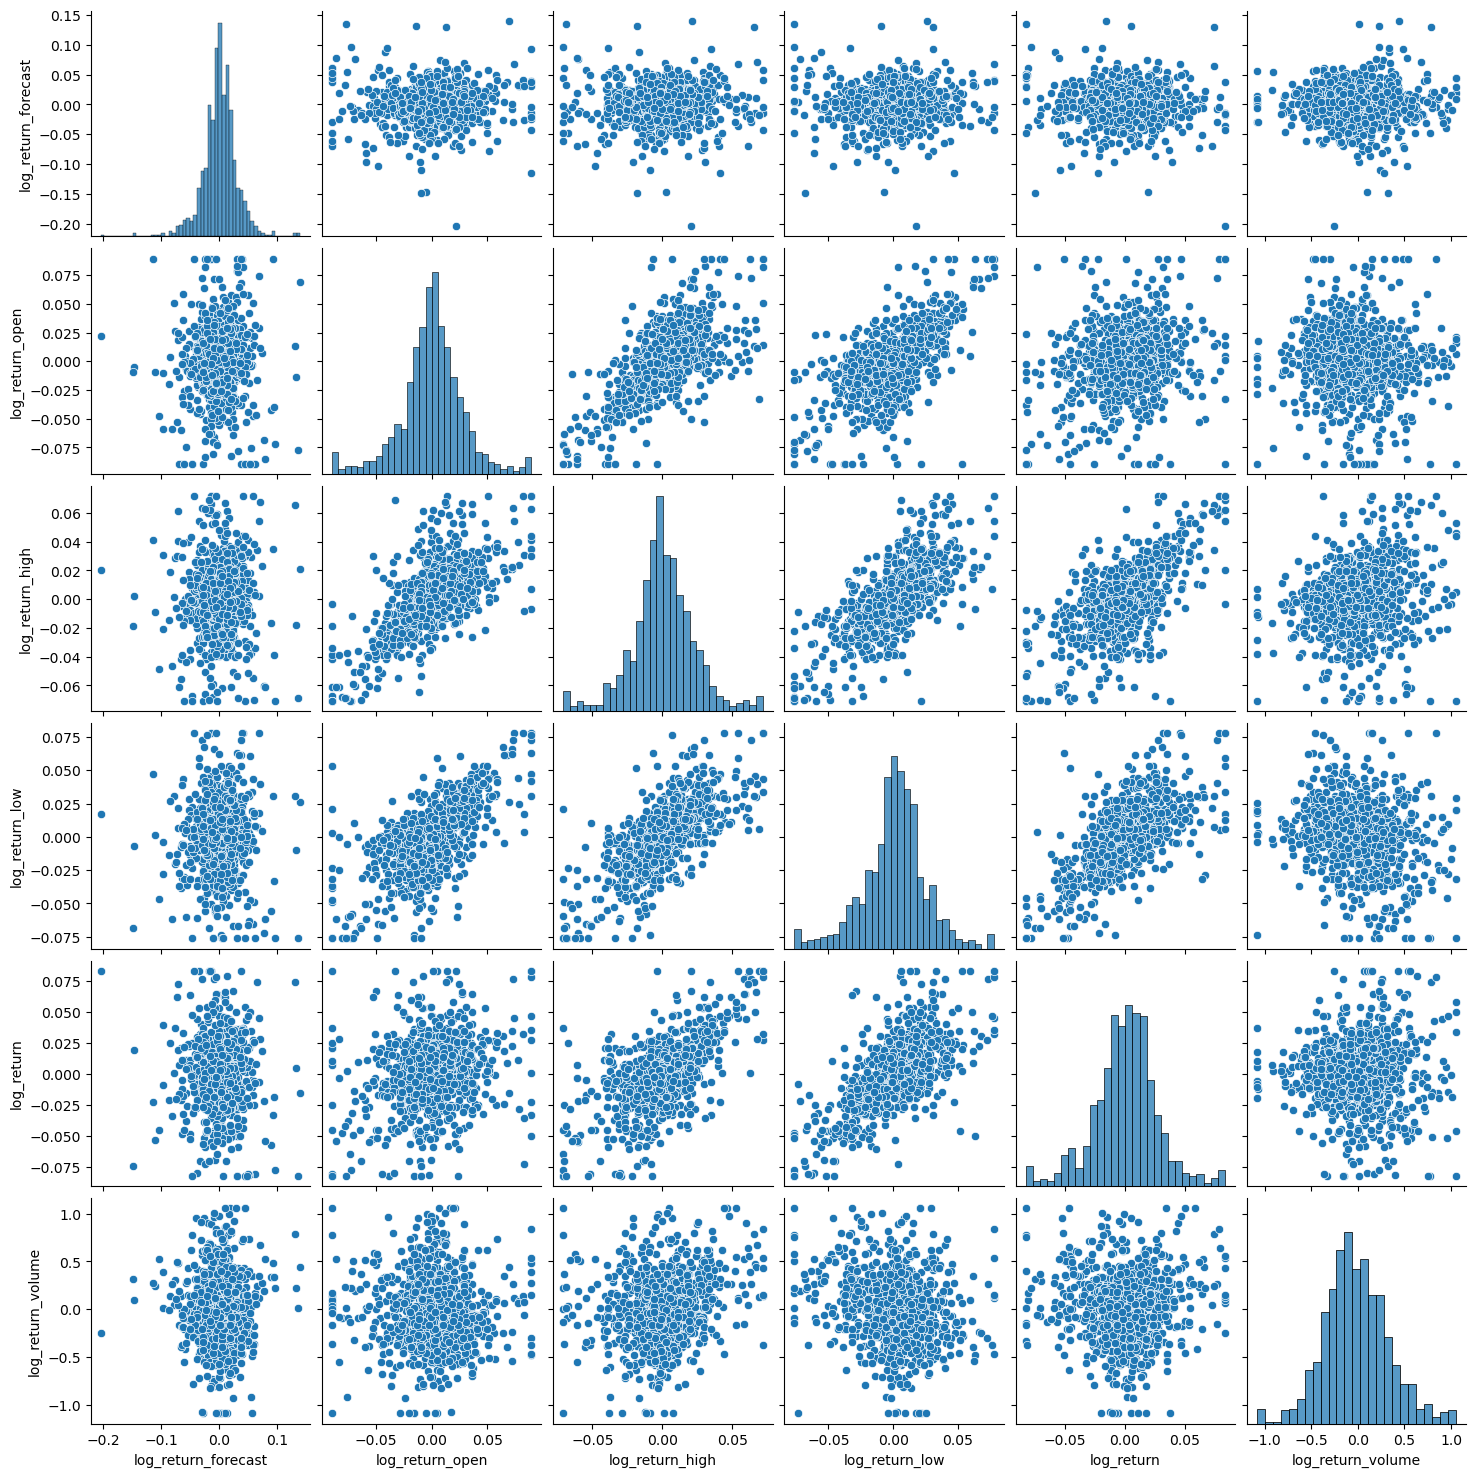

In [80]:
from src.data.assess import treat_outliers

df["log_return"] = treat_outliers(df["log_return"])
df["log_return_open"] = treat_outliers(df["log_return_open"])
df["log_return_high"] = treat_outliers(df["log_return_high"])
df["log_return_low"] = treat_outliers(df["log_return_low"])
df["log_return_volume"] = treat_outliers(df["log_return_volume"])
_ = sns.pairplot(df[features], kind="scatter", diag_kind="hist")


/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

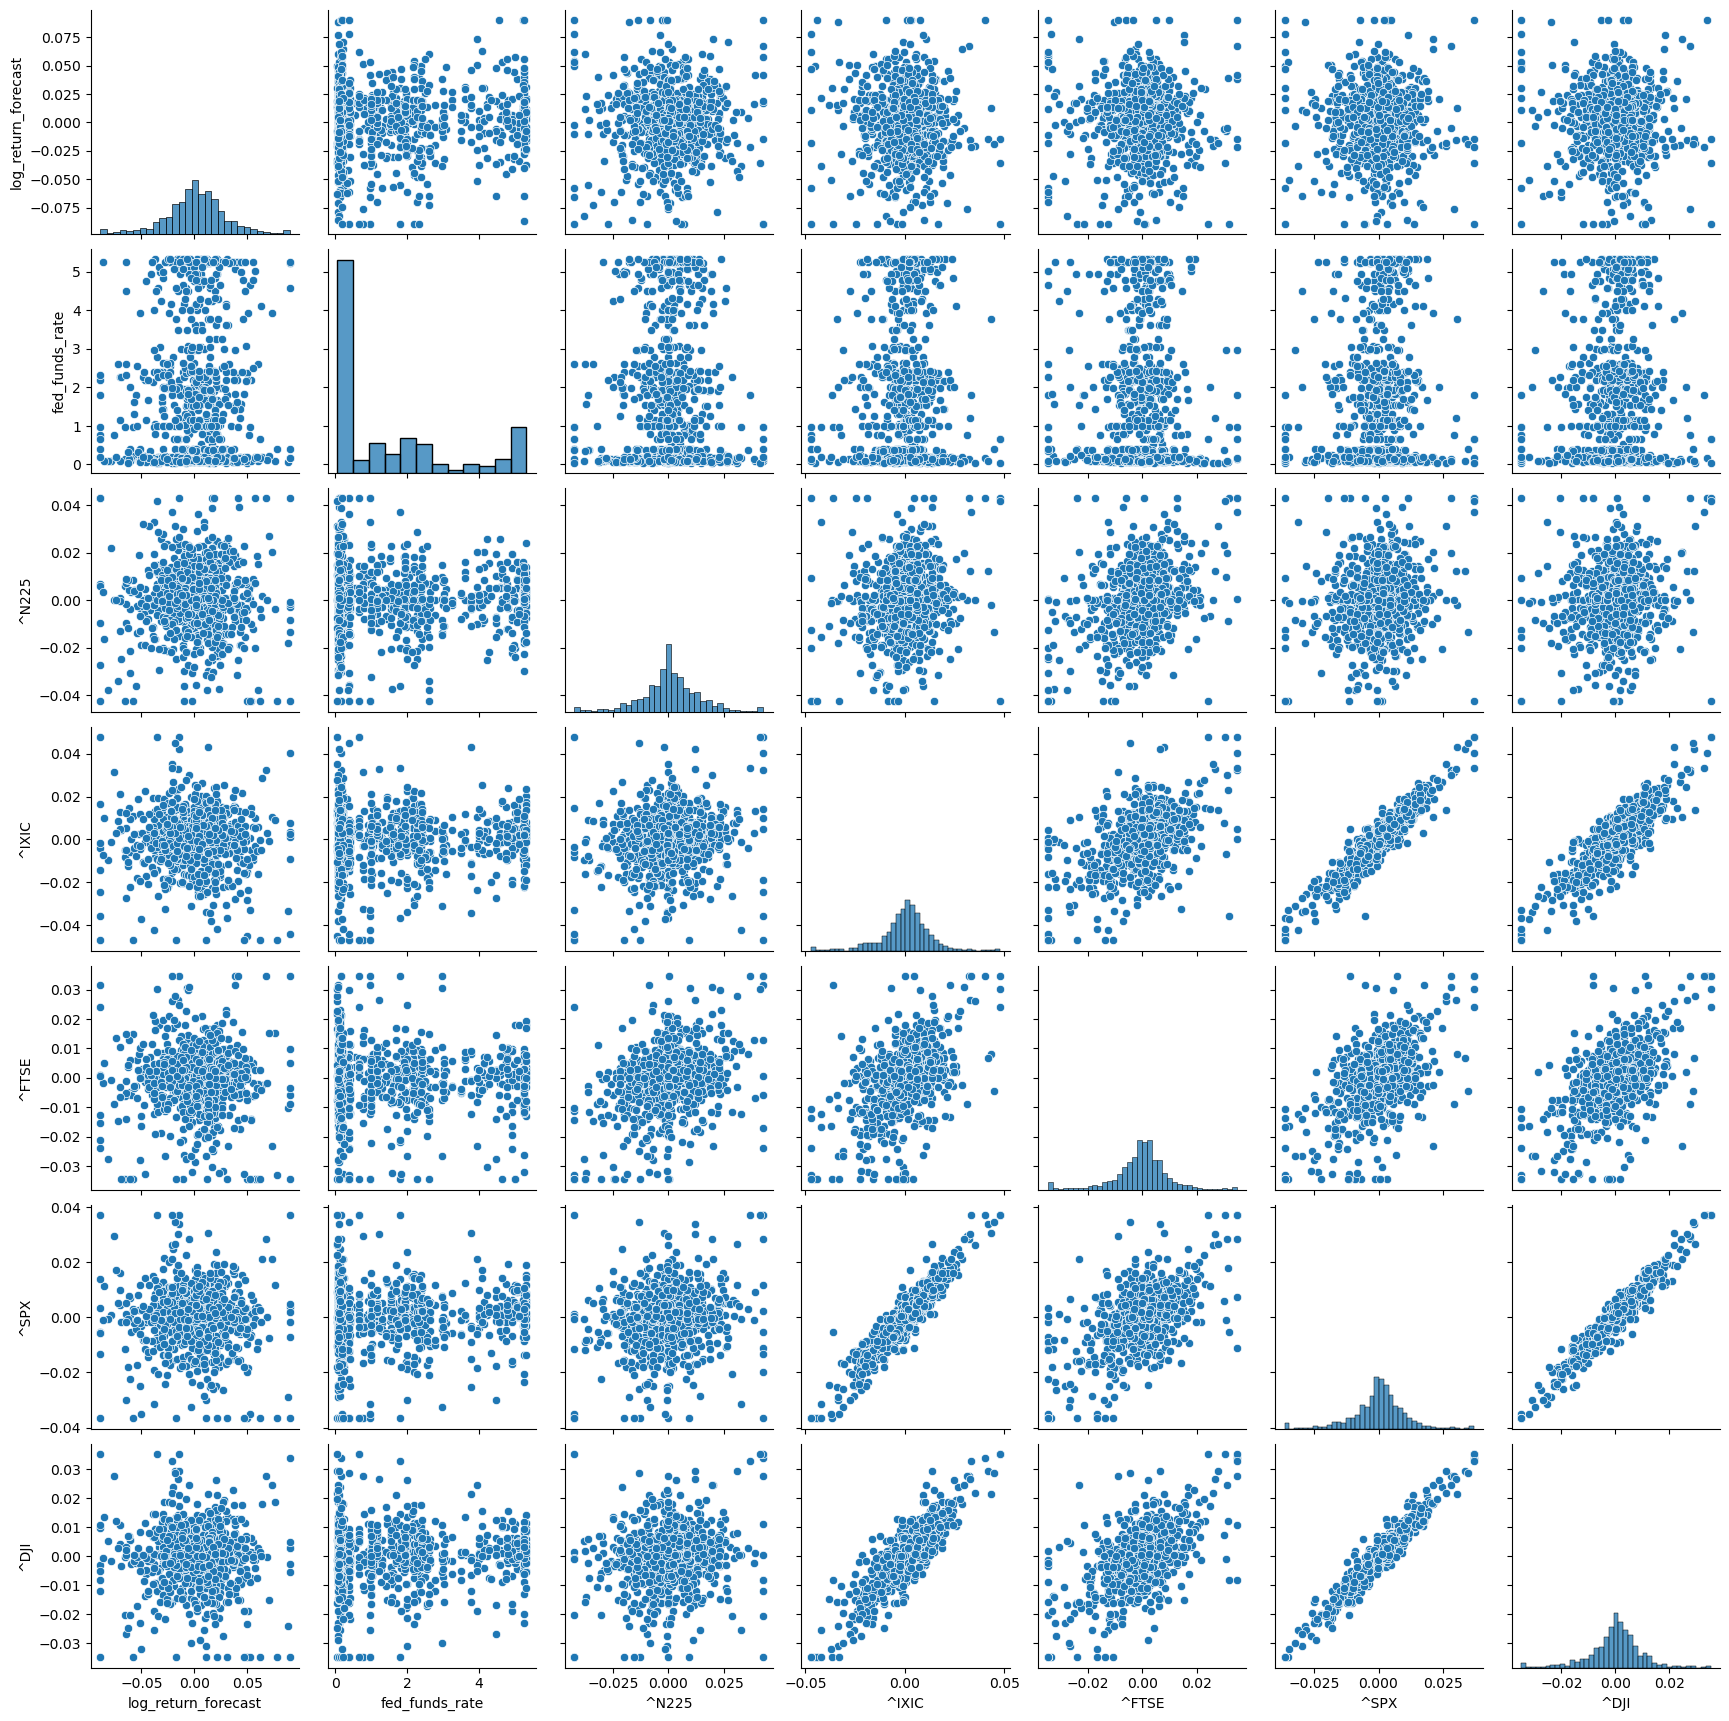

In [81]:
features = ['log_return_forecast', 'fed_funds_rate', '^N225', '^IXIC', '^FTSE', '^SPX', '^DJI']
df["log_return_forecast"] = treat_outliers(df["log_return_forecast"])
_ = sns.pairplot(df[features], kind="scatter", diag_kind="hist")

# Results

In [3]:
from src.evaluate import main

In [9]:
models = ["Linear", "ARIMA", "RF", "CNN", "LSTM", "ConvLSTM"]
stocks = ["NVDA", "JPM", "HD", "UNH"]

dfs = []
for m in models:
    for s in stocks:
        dfs.append(main(f"{m}_{s}"))
dfs = pd.concat(dfs)

Loading ARIMA_NVDA.
Rank 1: trial no. 11, value: 55.77689243027888. Run completed at 2024-04-25 17:53:29.038832


/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Loading ARIMA_JPM.
Rank 1: trial no. 0, value: 51.79282868525896. Run completed at 2024-04-26 13:03:32.002867


/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Loading ARIMA_HD.
Rank 1: trial no. 0, value: 52.589641434262944. Run completed at 2024-04-26 13:04:00.309358


/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Loading ARIMA_UNH.
Rank 1: trial no. 1, value: 47.01195219123506. Run completed at 2024-04-26 13:03:58.459789
Loading RF_NVDA.
Rank 1: trial no. 52, value: 53.78486055776892. Run completed at 2024-04-25 17:14:04.319365
Loading RF_JPM.
Rank 1: trial no. 99, value: 56.573705179282875. Run completed at 2024-04-26 12:38:16.419856
Loading RF_HD.
Rank 1: trial no. 67, value: 58.56573705179283. Run completed at 2024-04-26 12:57:02.371844
Loading RF_UNH.
Rank 1: trial no. 50, value: 58.56573705179283. Run completed at 2024-04-26 12:15:26.845256
Loading CNN_NVDA.
Rank 1: trial no. 7, value: 0.5737051963806152. Run completed at 2024-04-26 09:42:08.302978


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Loading CNN_JPM.
Rank 1: trial no. 3, value: 0.5697211027145386. Run completed at 2024-04-26 14:57:15.841831


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Loading CNN_HD.
Rank 1: trial no. 1, value: 0.5856573581695557. Run completed at 2024-04-26 14:54:50.537321


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Loading CNN_UNH.
Rank 1: trial no. 9, value: 0.5856573581695557. Run completed at 2024-04-26 15:03:04.644022


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Loading LSTM_NVDA.
Rank 1: trial no. 3, value: 0.5697211027145386. Run completed at 2024-04-26 14:54:29.394223


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading LSTM_JPM.
Rank 1: trial no. 2, value: 0.5697211027145386. Run completed at 2024-04-26 14:13:38.104590


/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Loading LSTM_HD.
Rank 1: trial no. 3, value: 0.5896414518356323. Run completed at 2024-04-26 14:17:11.406219


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading LSTM_UNH.
Rank 1: trial no. 7, value: 0.5856573581695557. Run completed at 2024-04-26 14:31:36.176553


/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Loading ConvLSTM_NVDA.
Rank 1: trial no. 1, value: 0.5180528163909912. Run completed at 2024-04-26 14:49:53.432673


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Loading ConvLSTM_JPM.
Rank 1: trial no. 7, value: 0.5261878967285156. Run completed at 2024-04-26 15:02:36.969138


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading ConvLSTM_HD.
Rank 1: trial no. 4, value: 0.5205575823783875. Run completed at 2024-04-26 15:00:51.259481


/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Loading ConvLSTM_UNH.
Rank 1: trial no. 0, value: 0.5577689409255981. Run completed at 2024-04-26 14:58:19.938676


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/var/folders/d7/ktx3dym91yjgj_gpmnfs0rh00000gn/T/ipykernel_19267/1094136895.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs)


In [10]:
dfs.to_clipboard()

In [12]:
dfs

Validation set                                               \
                          R2        MSE       RMSE        MAE           p   
Linear_NVDA      -0.02032910 0.00160738 0.04009212 0.03229121 -0.02176067   
Linear_JPM       -0.05145637 0.00036812 0.01918655 0.01493893 -0.05099169   
Linear_HD         0.00003922 0.00038992 0.01974641 0.01514499  0.09346435   
Linear_UNH       -0.01092422 0.00023882 0.01545390 0.01197685  0.00677099   
ARIMA_NVDA       -0.94080786 0.00305746 0.05529427 0.04459971 -0.02892084   
ARIMA_JPM        -0.98187689 0.00069387 0.02634145 0.02094081  0.08342033   
ARIMA_HD         -0.76868564 0.00068967 0.02626165 0.02072121  0.02820820   
ARIMA_UNH        -1.02506741 0.00047841 0.02187251 0.01737936 -0.01799291   
RF_NVDA          -0.01708988 0.00160227 0.04002843 0.03220919  0.03689415   
RF_JPM           -0.01362360 0.00035488 0.01883821 0.01462693  0.05775479   
RF_HD            -0.03234874 0.00040255 0.02006365 0.01522650  0.03196645   
RF_UNH            0.02585952 0.00023013 0.01517014 0.01174243  0.16162112   
CNN_NVDA          0.02322103 0.00153877 0.03922717 0.03162582  0.18947307   
CNN_JPM          -0.11767550 0.00039131 0.01978150 0.01525048  0.04088540   
CNN_HD           -0.39811258 0.00054517 0.02334897 0.01798381  0.12560611   
CNN_UNH          -0.04152441 0.00024605 0.01568605 0.01190930 -0.02690587   
LSTM_NVDA        -0.00489788 0.00158307 0.03978779 0.03199460  0.00931798   
LSTM_JPM         -0.00882880 0.00035320 0.01879360 0.01446317 -0.06497967   
LSTM_HD         -41.24784846 0.01647396 0.12835093 0.09559005  0.18276092   
LSTM_UNH          0.00209091 0.00023575 0.01535410 0.01185890  0.14033948   
ConvLSTM_NVDA    -0.00407773 0.00158178 0.03977155 0.03202700 -0.04698524   
ConvLSTM_JPM     -0.00428534 0.00035161 0.01875123 0.01447824 -0.02325311   
ConvLSTM_HD      -0.00334840 0.00039124 0.01977983 0.01495842 -0.01548363   
ConvLSTM_UNH   -137.39350867 0.03269441 0.18081597 0.17233454 -0.04092201   

                                                               \
                 Accuracy Avg. daily return Std. daily return   
Linear_NVDA   45.01992032       -0.00302368        0.03134156   
Linear_JPM    46.61354582       -0.00093825        0.01449701   
Linear_HD     52.58964143        0.00061622        0.01621591   
Linear_UNH    47.80876494       -0.00014321        0.01196517   
ARIMA_NVDA    55.77689243       -0.00131187        0.02671256   
ARIMA_JPM     51.79282869        0.00016246        0.01139880   
ARIMA_HD      52.58964143       -0.00048920        0.01303201   
ARIMA_UNH     47.01195219       -0.00046330        0.01100797   
RF_NVDA       51.39442231       -0.00110418        0.03561227   
RF_JPM        52.19123506       -0.00024731        0.01392760   
RF_HD         52.58964143        0.00013578        0.01384653   
RF_UNH        54.98007968        0.00056093        0.01382136   
CNN_NVDA      57.37051793        0.00205918        0.01868238   
CNN_JPM       56.97211155        0.00090859        0.00527907   
CNN_HD        58.56573705        0.00091451        0.01127166   
CNN_UNH       58.56573705        0.00037855        0.01194488   
LSTM_NVDA     56.97211155        0.00058106        0.02243798   
LSTM_JPM      56.97211155        0.00005379        0.00947569   
LSTM_HD       58.96414343        0.00125174        0.01205185   
LSTM_UNH      58.56573705        0.00117903        0.01284449   
ConvLSTM_NVDA 51.39442231       -0.00009791        0.00209521   
ConvLSTM_JPM  52.19123506       -0.00007934        0.00124466   
ConvLSTM_HD   52.98804781        0.00020299        0.01070637   
ConvLSTM_UNH  55.77689243        0.00017841        0.01541678   

                                    Test set                                   \
              Risk adj. return            R2        MSE       RMSE        MAE   
Linear_NVDA        -0.09647500   -0.03183256 0.00089379 0.02989628 0.02122879   
Linear_JPM         -0.06472044   -0.03836857 0.00017654 0.01328686 0.00953304

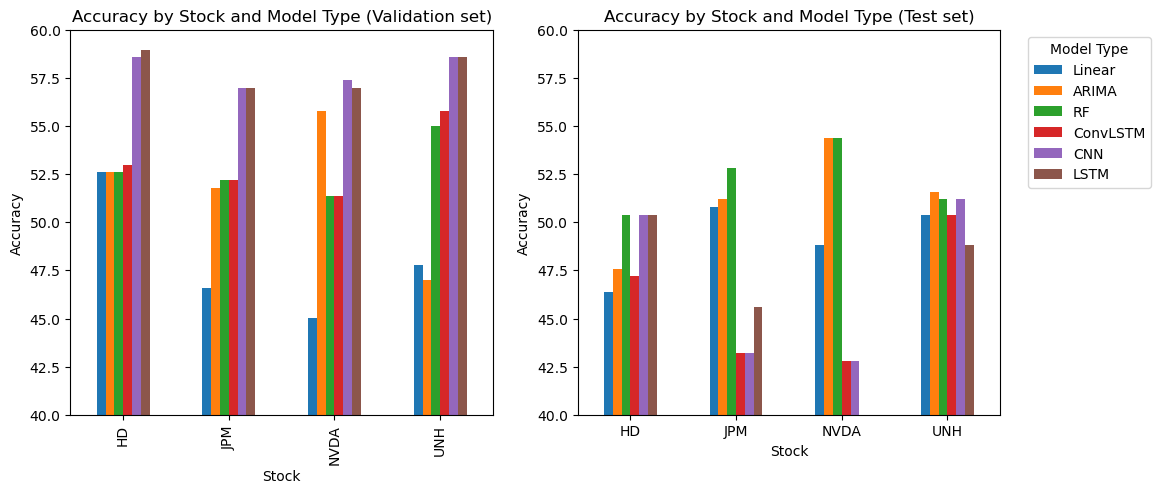

In [67]:
df = dfs.copy()
df['model_type'] = df.index.str.split('_').str[0]
df['stock'] = df.index.str.split('_').str[1]

# Plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

val_df = df.pivot(index='stock', columns='model_type', values=("Validation set", "Accuracy"))
val_df = val_df[['Linear', 'ARIMA', 'RF', 'ConvLSTM', 'CNN', 'LSTM']]
val_df.plot(kind='bar', ax=axs[0], )
axs[0].set_title('Accuracy by Stock and Model Type (Validation set)')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Stock')
plt.xticks(rotation=0)
axs[0].set_ylim([40, 60]) 
axs[0].get_legend().remove()

test_df = df.pivot(index='stock', columns='model_type', values=("Test set", "Accuracy"))
test_df = test_df[['Linear', 'ARIMA', 'RF', 'ConvLSTM', 'CNN', 'LSTM']]
test_df.plot(kind='bar', ax=axs[1])
axs[1].set_title('Accuracy by Stock and Model Type (Test set)')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Stock')
plt.xticks(rotation=0)
axs[1].set_ylim([40, 60]) 

axs[1].legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
